# Setup

#### Load Packages

In [1]:
%load_ext autoreload
%load_ext line_profiler
%autoreload 2

# import packages
import numpy as np
import matplotlib.pyplot as plt

# import modules
import Bargaining as brg
from figures import *
from checks import *

#### Compile C++ files

In [2]:
# compile c++ files
model = brg.HouseholdModelClass(par={'do_cpp':True,'num_Ctot':100})
try:
    model.link_to_cpp(force_compile=True)
except:
    model.cpp.delink()
    model.link_to_cpp(force_compile=True)

## Model Settings

#### Specify Models

In [3]:
# Default settings
T = 2
do_load = False
do_save = False
threads = 4

# Model settings
specs = {
       'VFI':    
              {'latexname':'', 
              'load': do_load,
              'save': do_save,
              'par':{'T':T,
                     'do_cpp':True,
                     'threads':threads,
                     
                     'div_A_share':0.3,
                     'sigma_love':0.0,
                     'R':1.2,
                     'do_egm':False,
                     'max_A': 15.0,
                     }
              },
              
       'EGM':    
              {'latexname':'', 
              'load': do_load,
              'save': do_save,
              'par':{'T':T,
                     'do_cpp':True,
                     'threads':threads,
                     
                     'div_A_share':0.3,
                     'sigma_love':0.0,
                     'R':1.2,
                     'do_egm':True,
                     'max_A': 15.0,
                     'analytic_marg_u_single':False,
                     'analytic_inv_marg_u_single':False,
                     'do_upper_env':True,
                     }
              },

       'weird VFI':    
              {'latexname':'', 
              'load': do_load,
              'save': do_save,
              'par':{'T':T,
                     'do_cpp':True,
                     'threads':threads,
                     
                     'div_A_share':0.3,
                     'sigma_love':0.0,
                     'R':1.2,
                     'do_egm':False,
                     'max_A': 15.0,

                     'rho_w':4.0,
                     'alpha2_w':5.0,
                     }
              },

       'weird EGM':    
              {'latexname':'', 
              'load': do_load,
              'save': do_save,
              'par':{'T':T,
                     'do_cpp':True,
                     'threads':threads,
                     
                     'div_A_share':0.3,
                     'sigma_love':0.0,
                     'R':1.2,
                     'do_egm':True,
                     'max_A': 15.0,
                     'analytic_marg_u_single':False,
                     'analytic_inv_marg_u_single':False,
                     'do_upper_env':False,

                     'rho_w':4.0,
                     'alpha2_w':5.0,
                     }
              },
       'weird EGM with envelope':    
              {'latexname':'', 
              'load': do_load,
              'save': do_save,
              'par':{'T':T,
                     'do_cpp':True,
                     'threads':threads,
                     
                     'div_A_share':0.3,
                     'sigma_love':0.0,
                     'R':1.2,
                     'do_egm':True,
                     'max_A': 15.0,
                     'analytic_marg_u_single':False,
                     'analytic_inv_marg_u_single':False,
                     'do_upper_env':True,

                     'rho_w':4.0,
                     'alpha2_w':5.0,
                     }
              },

}

In [4]:
# get the first variable of specs
name = list(specs.keys())[0]

In [5]:
# Make table
print_specs_table(specs)

                          |           VFI            |           EGM            |        weird VFI         |        weird EGM         | weird EGM with envelope  |
------------------------------------------------------------------------------------------------------------------------------------------------------------------
max_A                     |           15.0           |           15.0           |           15.0           |           15.0           |           15.0           |
analytic_inv_marg_u_single|          False           |          False           |          False           |          False           |          False           |
T                         |            2             |            2             |            2             |            2             |            2             |
threads                   |            4             |            4             |            4             |            4             |            4             |
do_cpp                

#### Solve/Load models

In [6]:
# solve different models
models = {}
for name,spec in specs.items():
        #unpack
        par = spec['par']
        do_load = spec['load']
        do_save = spec['save']
        
        if do_load:
            print(f'loading {name}...')
        else:
            print(f'solving {name}...')
        
        # setup model
        models[name] = brg.HouseholdModelClass(name=name, par=spec['par'], load=do_load)
        models[name].spec = spec
        
        # link to cpp
        try:
            models[name].link_to_cpp(force_compile=False)
        except:
            models[name].cpp.delink()
            models[name].link_to_cpp(force_compile=False)
        
        # solve
        if not do_load:
            models[name].solve()
        
        # save model
        if do_save:
            models[name].save()
        
# Save model names
model_names  = list(models.keys())

solving VFI...
solving EGM...
solving weird VFI...
solving weird EGM...
solving weird EGM with envelope...


## Compare solutions

In [7]:
# Choose index
t  = 0
iP = 1
iL = 20
iA = 30
idx = (t,iP,iL,iA)

Value functions, woman

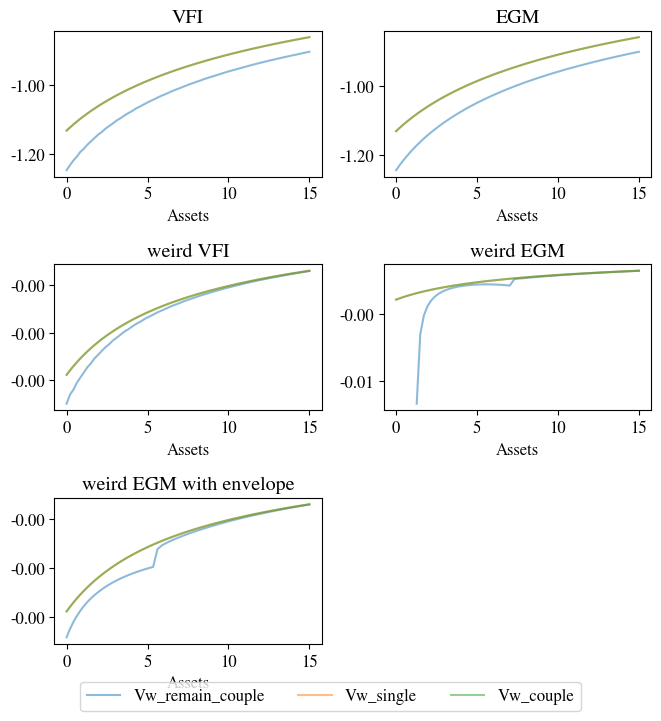

In [8]:
model_plot(models, plot_var_over_assets, ['Vw_remain_couple', 'Vw_single', 'Vw_couple'], idx=idx, asset_grid=False, shared_legend=True, subtitles=model_names)

Value functions, man

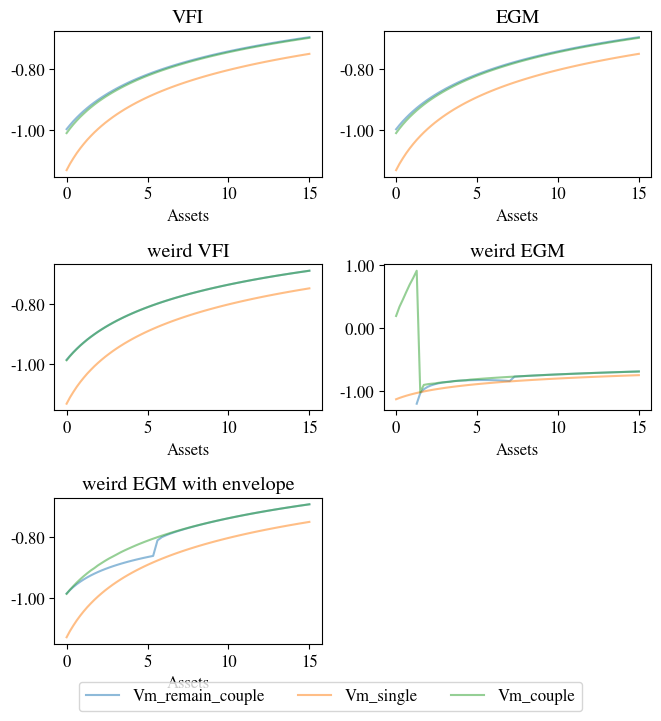

In [9]:
model_plot(models, plot_var_over_assets, ['Vm_remain_couple', 'Vm_single', 'Vm_couple'], idx=idx, asset_grid=False, shared_legend=True, subtitles=model_names)

Bargaining power

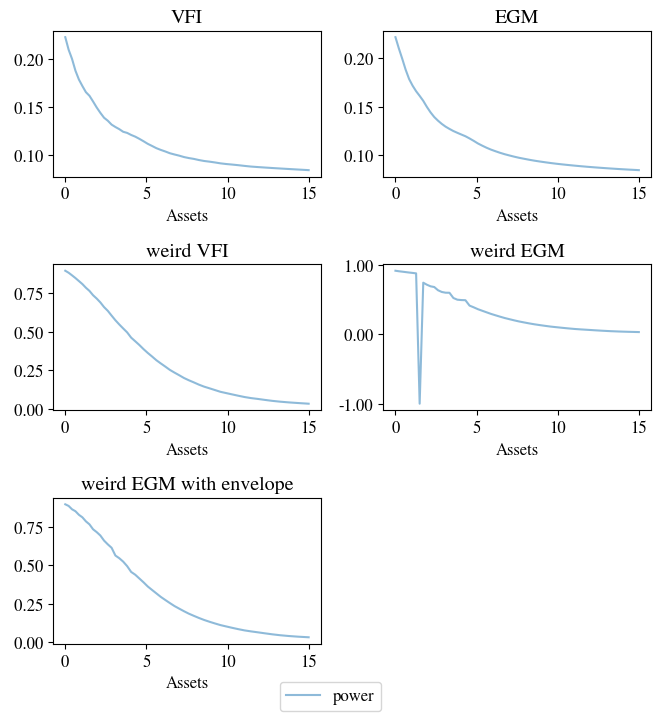

In [10]:
model_plot(models, plot_var_over_assets, ['power'], idx=idx, asset_grid=False, shared_legend=True, subtitles=model_names)

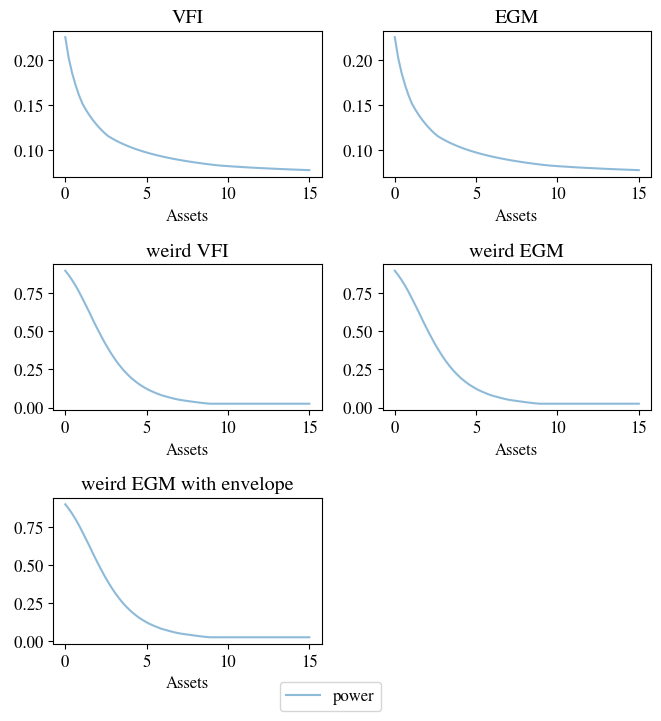

In [11]:
#Next period bargaining power
idx_lead = (t+1,iP,iL,iA)
model_plot(models, plot_var_over_assets, ['power'], idx=idx_lead, asset_grid=False, shared_legend=True, subtitles=model_names)

Total consumption

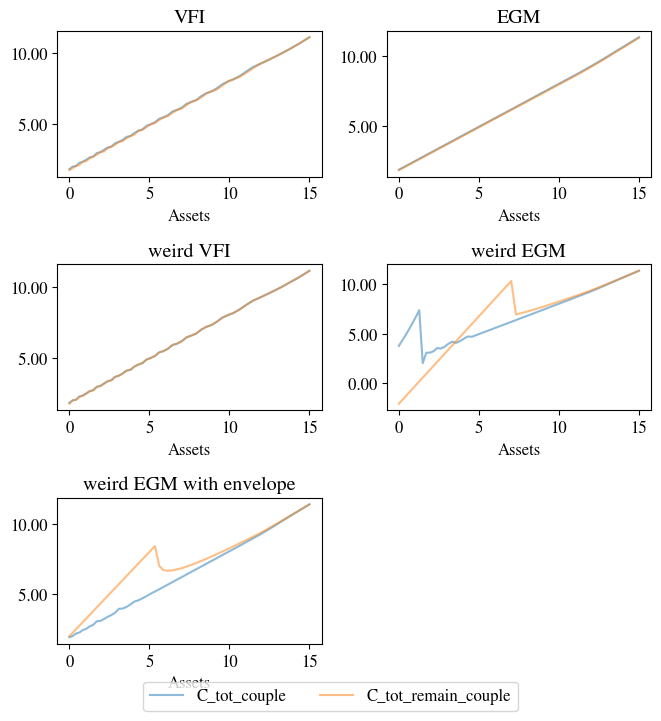

In [12]:
model_plot(models, plot_var_over_assets, ['C_tot_couple', 'C_tot_remain_couple'], idx=idx, asset_grid=False, shared_legend=True, subtitles=model_names)

## So what's going on with weird EGM?

Text(0.5, 1.0, 'Endogenous grid')

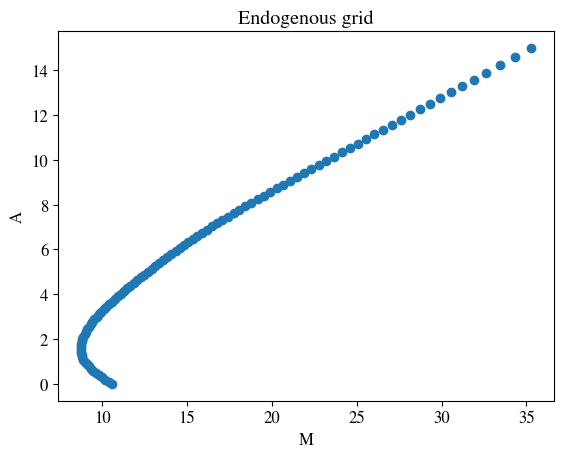

In [13]:
model = models['weird EGM with envelope']
sol = model.sol
par = model.par

plt.scatter(sol.M_pd[iP,iL],par.grid_A_pd)
plt.xlabel('M')
plt.ylabel('A')
plt.title("Endogenous grid")
# endogenous grid is crazy due to bargaining shifting the value function

A bunch of code doing upper envelope...

C:\Users\jmh520\AppData\Local\Temp\ipykernel_12056\3213205685.py:46: ComplexWarning: Casting complex values to real discards the imaginary part
  v_ast_vec[im] = value(c_ast_vec[im], grid_m[im])


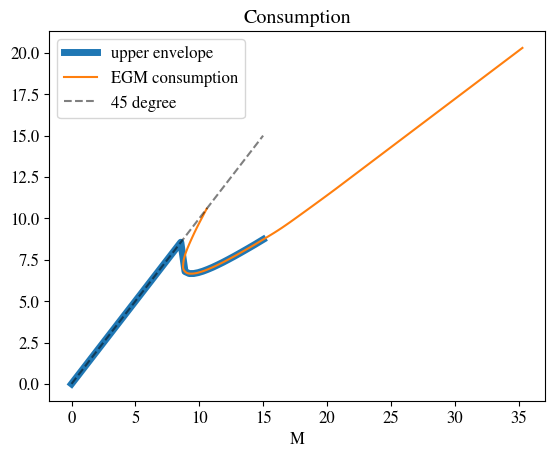

In [14]:
size = par.num_A_pd

C_now = np.zeros(size)
C_now[:] = sol.C_tot_pd[iP, iL,:] 

M_now = np.zeros(size)
M_now[:] = model.sol.M_pd[iP, iL,:]

V_now = np.zeros(size)
V_now[:] = model.sol.V_couple_pd[iP, iL,:]

Vm_next = np.zeros((par.num_love,par.num_A))
Vm_next[:,:] = model.sol.Vm_couple[t+1,iP,:,:]

Vw_next = np.zeros((par.num_love,par.num_A))
Vw_next[:,:] = model.sol.Vw_couple[t+1,iP,:,:]

value = lambda C,M: model.value_of_choice_couple(C, t, M, iL, iP, model.par.grid_power[iP], Vw_next, Vm_next)[0]

# Jeppe's algorithm
Na = par.num_A_pd
Nm = par.num_A

# post decision grid
grid_a = par.grid_A_pd
grid_m = par.grid_A

# endogenous grids
m_vec = sol.M_pd[iP, iL]
c_vec = sol.C_tot_pd[iP, iL]
w_vec = sol.V_couple_pd[iP, iL]

# common grid
c_ast_vec = np.zeros(Nm)
v_ast_vec = np.zeros(Nm) - np.inf


# constraint
# binding if common m is smaller than the smallest m implied by EGM step (m_vec[0])
im = 0
while im < Nm and grid_m[im] < m_vec[0]:
    # consume all
    c_ast_vec[im] = grid_m[im]

    # value of choice
    v_ast_vec[im] = value(c_ast_vec[im], grid_m[im])

    im +=1

for ia in range(Na-1):
    a_low = grid_a[ia]
    a_high = grid_a[ia+1]

    # w_low = w_vec[ia]
    # w_high = w_vec[ia+1]

    if a_low>a_high:
        continue

    # w_slope = (w_high-w_low)/(a_high-a_low)

    # m interval and c slope
    m_low = m_vec[ia]
    m_high = m_vec[ia+1]

    c_low = c_vec[ia]
    c_high = c_vec[ia+1]

    c_slope = (c_high-c_low)/(m_high-m_low)

    # loop through common grid
    for im in range(Nm):
        # current m
        m = grid_m[im]

        # interpolate?
        interp = (m>m_low) and (m<m_high)
        extrap_above = ia==Na-2 and m>m_vec[Na-1] # return to this

        # interpolation or extrapolation
        if interp or extrap_above:

            # implied guess:
            c_guess = c_low + c_slope*(m-m_low)
            a_guess = m - c_guess

            # implied post-decision value fnuction
            # w = w_low + w_slope*(a_guess-a_low)

            # value of choice
            v_guess = value(c_guess, m)

            # update
            if v_guess > v_ast_vec[im]:
                c_ast_vec[im] = c_guess
                v_ast_vec[im] = v_guess

plt.plot(grid_m, c_ast_vec, linewidth=5, label='upper envelope')
plt.plot(m_vec,c_vec, label='EGM consumption')
plt.plot(grid_m, grid_m, color='black', linestyle='--', alpha=0.5, label='45 degree')
plt.legend()
plt.xlabel('M')
plt.title('Consumption');

Resulting in...

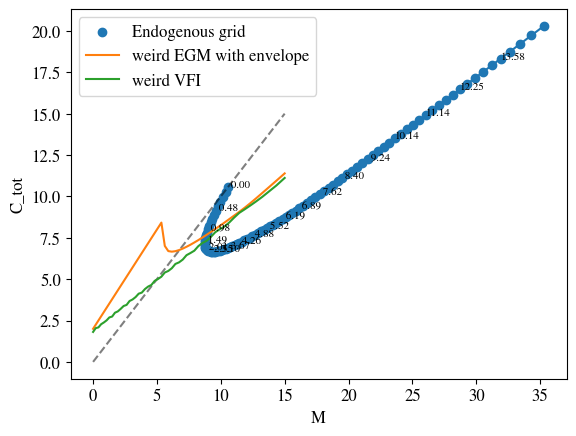

In [15]:
plt.plot(sol.M_pd[iP,iL],sol.C_tot_pd[iP, iL])

# scatter plot of the same thing with numbers on the grid points
plt.scatter(sol.M_pd[iP,iL],sol.C_tot_pd[iP, iL], label="Endogenous grid")
for i in range(0, len(sol.M_pd[iP,iL])):
    if i % 5 == 0:
        plt.text(sol.M_pd[iP,iL][i],sol.C_tot_pd[iP, iL][i], f"{par.grid_A_pd[i]:5.2f}", fontsize=8)

plt.plot(par.grid_A,par.grid_A, color='black', linestyle='--', alpha=0.5)

plt.xlabel('M')
plt.ylabel('C_tot')

plt.plot(par.grid_A, sol.C_tot_remain_couple[t,iP,iL,:], label=model.name)
plt.plot(models['weird VFI'].par.grid_A, models['weird VFI'].sol.C_tot_remain_couple[t,iP,iL,:], label=models['weird VFI'].name)
plt.legend();